SARIMA Solar Energy Supply Model

In [257]:
# Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
from functools import reduce
import hvplot.pandas
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from time import time
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [176]:
# Read in Data from CSV
date_cols = ["Date"]
annual_solar_supply = pd.read_csv("/Users/erahm/Downloads/CA Energy Data/Utility Scale Solar Generation.csv", parse_dates=date_cols)
annual_solar_supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           72 non-null     object 
 1   Date          72 non-null     object 
 2   Value         72 non-null     float64
 3   Column_Order  72 non-null     int64  
 4   Description   72 non-null     object 
 5   Unit          72 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 3.5+ KB


In [177]:
# Convert 'Date' column to datetime 
annual_solar_supply['Date'] = pd.to_datetime(annual_solar_supply['Date'], format='%Y%m')
print(annual_solar_supply)
annual_solar_supply.info()

        MSN       Date      Value  Column_Order  \
0   SOEGPUS 2016-01-01   1458.182             7   
1   SOEGPUS 2016-02-01   2200.546             7   
2   SOEGPUS 2016-03-01   2570.772             7   
3   SOEGPUS 2016-04-01   2831.115             7   
4   SOEGPUS 2016-05-01   3375.003             7   
..      ...        ...        ...           ...   
67  SOEGPUS 2021-08-01  11733.500             7   
68  SOEGPUS 2021-09-01  11029.492             7   
69  SOEGPUS 2021-10-01   9176.915             7   
70  SOEGPUS 2021-11-01   7812.802             7   
71  SOEGPUS 2021-12-01   6306.888             7   

                                          Description                   Unit  
0   Utility-Scale Solar Electricity Net Generation...  Million Kilowatthours  
1   Utility-Scale Solar Electricity Net Generation...  Million Kilowatthours  
2   Utility-Scale Solar Electricity Net Generation...  Million Kilowatthours  
3   Utility-Scale Solar Electricity Net Generation...  Million Kilowatt

In [178]:
# Create and Review Data in Dataframe
annual_solar_supply_df = pd.DataFrame(annual_solar_supply).iloc[:, [1,2,4,5]]
annual_solar_supply_df.set_index('Date')

,Value,Description,Unit
Date,,,
2016-01-01,1458.182,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2016-02-01,2200.546,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2016-03-01,2570.772,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2016-04-01,2831.115,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2016-05-01,3375.003,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
...,...,...,...
2021-08-01,11733.500,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2021-09-01,11029.492,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours
2021-10-01,9176.915,Utility-Scale Solar Electricity Net Generation...,Million Kilowatthours


In [179]:
# Drop Remaining Unnecessary Rows as we will be predicting 'Value'
final_solar_supply_df = pd.DataFrame(annual_solar_supply).iloc[:, [1,2]].set_index('Date')
final_solar_supply_df#.info()

,Value
Date,
2016-01-01,1458.182
2016-02-01,2200.546
2016-03-01,2570.772
2016-04-01,2831.115
2016-05-01,3375.003
...,...
2021-08-01,11733.500
2021-09-01,11029.492
2021-10-01,9176.915


In [180]:
# Plot Data to be Predicted
(final_solar_supply_df.hvplot(y='Value', kind='scatter', width=3000) +
final_solar_supply_df.hvplot.table(['Value'], width=420))

:Layout
   .Scatter.I :Scatter   [Date]   (Value)
   .Table.I   :Table   [Value]

In [181]:
final_solar_supply_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all Rows with NaN Values
final_solar_supply_df.dropna(inplace=True)
print(final_solar_supply_df)
final_solar_supply_df.info()

                Value
Date                 
2016-01-01   1458.182
2016-02-01   2200.546
2016-03-01   2570.772
2016-04-01   2831.115
2016-05-01   3375.003
...               ...
2021-08-01  11733.500
2021-09-01  11029.492
2021-10-01   9176.915
2021-11-01   7812.802
2021-12-01   6306.888

[72 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2016-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [182]:
# Split Data into a Training Set and Testing Set
y_train=final_solar_supply_df.Value[:len(annual_solar_supply_df.Value)-14]
y_test=final_solar_supply_df.Value[(len(annual_solar_supply_df.Value)-14):]

In [239]:
# View a few rows of Training Dataset
y_train[-2:]

Date
2020-09-01    7672.880
2020-10-01    7034.284
Name: Value, dtype: float64

In [241]:
# View Testing Dataset
y_test

Date
2020-11-01     5724.592
2020-12-01     5058.137
2021-01-01     5683.218
2021-02-01     6370.142
2021-03-01     9203.562
2021-04-01    10751.438
2021-05-01    12206.852
2021-06-01    11763.599
2021-07-01    11832.855
2021-08-01    11733.500
2021-09-01    11029.492
2021-10-01     9176.915
2021-11-01     7812.802
2021-12-01     6306.888
Name: Value, dtype: float64

In [184]:
# Plot Training Data
y_train.hvplot(width=3000)

:Curve   [Date]   (Value)

In [185]:
# Plot Testing Data
y_test.hvplot(width=3000)

:Curve   [Date]   (Value)

Remove the Trend and Confirm Stationarity

In [186]:
# Test for Stationarity with the AD Fuller Test
result = adfuller(final_solar_supply_df)

# Access the contents of the results:
print('ADF Statistic: %f' % result[0])
print('p-value:        %f ' % result[1])
print('Lags used:      %d' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print((key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Hypothesis - Time Series is Stationary")
else:
    print ("Failed to Reject Hypothesis - Time Series is Non-Stationary")

ADF Statistic: 1.584867
p-value:        0.997811 
Lags used:      9
Critical Values:
('1%', -3.540522678829176)
('5%', -2.9094272025108254)
('10%', -2.5923136524453696)
Failed to Reject Hypothesis - Time Series is Non-Stationary


In [187]:
# Take first difference of 'Value' column
final_solar_supply_df['Diff_1'] = final_solar_supply_df['Value'].diff()
final_solar_supply_df

,Value,Diff_1
Date,,
2016-01-01,1458.182,NaN
2016-02-01,2200.546,742.364
2016-03-01,2570.772,370.226
2016-04-01,2831.115,260.343
2016-05-01,3375.003,543.888
...,...,...
2021-08-01,11733.500,-99.355
2021-09-01,11029.492,-704.008
2021-10-01,9176.915,-1852.577


In [188]:
# Remove any newly added NaN Values in 'Diff_1' column
final_solar_supply_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all Rows with NaN Values
final_solar_supply_df.dropna(inplace=True)
print(final_solar_supply_df)
final_solar_supply_df.info()

                Value    Diff_1
Date                           
2016-02-01   2200.546   742.364
2016-03-01   2570.772   370.226
2016-04-01   2831.115   260.343
2016-05-01   3375.003   543.888
2016-06-01   3417.726    42.723
...               ...       ...
2021-08-01  11733.500   -99.355
2021-09-01  11029.492  -704.008
2021-10-01   9176.915 -1852.577
2021-11-01   7812.802 -1364.113
2021-12-01   6306.888 -1505.914

[71 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2016-02-01 to 2021-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   71 non-null     float64
 1   Diff_1  71 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB


In [189]:
# Second Test for Stationarity with the AD Fuller Test
result = adfuller(final_solar_supply_df.Diff_1)

# Access the contents of the results:
print('ADF Statistic: %f' % result[0])
print('p-value:        %f ' % result[1])
print('Lags used:      %d' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print((key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Hypothesis - Time Series is Stationary")
else:
    print ("Failed to Reject Hypothesis - Time Series is Non-Stationary")

ADF Statistic: -8.119001
p-value:        0.000000 
Lags used:      8
Critical Values:
('1%', -3.540522678829176)
('5%', -2.9094272025108254)
('10%', -2.5923136524453696)
Reject Hypothesis - Time Series is Stationary


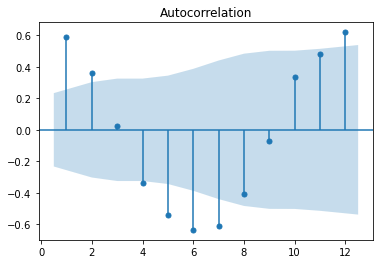

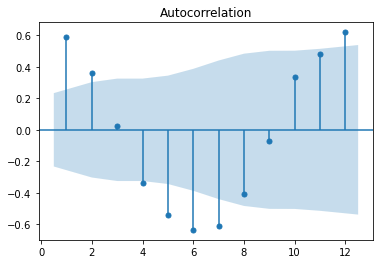

In [190]:
# Plot the ACF
plot_acf(final_solar_supply_df.Diff_1, lags=12, zero=False)

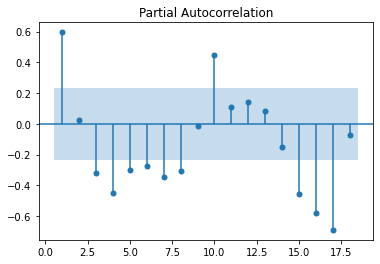

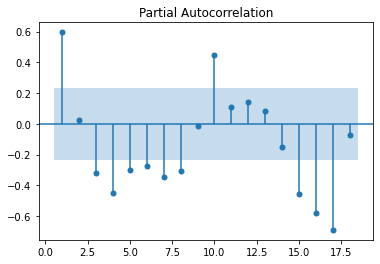

In [191]:
# Plot the PACF
plot_pacf(final_solar_supply_df.Diff_1, lags=18, zero=False)

Fit SARIMA Model and Identify Optimal Parameters

In [203]:
# Fit the SARIMA Model based on chosen parameters
model = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0,1,0),
                                seasonal_order=(1, 0, 1, 12))
model_aic = model.fit()
print(model_aic.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8611      0.156      5.512      0.000       0.555       1.167
ma.S.L12      -0.2592      0.349     -0.743      0.458      -0.943       0.425
sigma2      3.065e+05    7.4e+04      4.142      0.000    1.61e+05    4.51e+05


In [204]:
# Print full summary of SARIMA Model
model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Value   No. Observations:                   58
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -446.437
Date:                              Sun, 24 Apr 2022   AIC                            898.873
Time:                                      17:34:41   BIC                            905.003
Sample:                                  01-01-2016   HQIC                           901.255
                                       - 10-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8611      0.156      5.512      0.000       0.555       1.167
ma.S.L12      -0.2592      0.349     -0.743      0.458      -0.943       0.425
sigma2      3.065e+05    7.4e+04      4.142      0.000    1.61e+05    4.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.86   Prob(JB):                         0.64
Heteroskedasticity (H):               2.17   Skew:                             0.30
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
# Fit the SARIMA Model based on chosen parameters
model_2 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1,1,0),
                                seasonal_order=(1, 0, 1, 12))
model_aic_2 = model_2.fit()
print(model_aic_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0434      0.145      0.299      0.765      -0.241       0.328
ar.S.L12       0.8565      0.188      4.548      0.000       0.487       1.226
ma.S.L12      -0.2779      0.391     -0.710      0.478      -1.045       0.489
sigma2      3.101e+05   8.09e+04      3.831      0.000    1.51e+05    4.69e+05


In [206]:
# Print full summary of SARIMA Model
model_aic_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Value   No. Observations:                   58
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -446.406
Date:                              Sun, 24 Apr 2022   AIC                            900.813
Time:                                      17:35:04   BIC                            908.985
Sample:                                  01-01-2016   HQIC                           903.989
                                       - 10-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0434      0.145      0.299      0.765      -0.241       0.328
ar.S.L12       0.8565      0.188      4.548      0.000       0.487       1.226
ma.S.L12      -0.2779      0.391     -0.710      0.478      -1.045       0.489
sigma2      3.101e+05   8.09e+04      3.831      0.000    1.51e+05    4.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.99   Prob(JB):                         0.67
Heteroskedasticity (H):               2.21   Skew:                             0.29
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [207]:
# Fit the SARIMA Model based on chosen parameters
model_3 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0,1,1),
                                seasonal_order=(1, 0, 1, 12))
model_aic_3 = model_3.fit()
print(model_aic_3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0443      0.140      0.317      0.751      -0.230       0.319
ar.S.L12       0.8566      0.189      4.522      0.000       0.485       1.228
ma.S.L12      -0.2780      0.397     -0.701      0.483      -1.056       0.499
sigma2      3.101e+05   8.07e+04      3.843      0.000    1.52e+05    4.68e+05


In [208]:
# Print full summary of SARIMA Model
model_aic_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                   58
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -446.406
Date:                            Sun, 24 Apr 2022   AIC                            900.811
Time:                                    17:36:07   BIC                            908.983
Sample:                                01-01-2016   HQIC                           903.987
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0443      0.140      0.317      0.751      -0.230       0.319
ar.S.L12       0.8566      0.189      4.522      0.000       0.485       1.228
ma.S.L12      -0.2780      0.397     -0.701      0.483      -1.056       0.499
sigma2      3.101e+05   8.07e+04      3.843      0.000    1.52e+05    4.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.98   Prob(JB):                         0.67
Heteroskedasticity (H):               2.21   Skew:                             0.29
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [209]:
# Fit the SARIMA Model based on chosen parameters
model_4 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0,1,1),
                                seasonal_order=(0, 0, 1, 12))
model_aic_4 = model_4.fit()
print(model_aic_4.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7044      0.093      7.557      0.000       0.522       0.887
ma.S.L12      -1.0000      0.160     -6.266      0.000      -1.313      -0.687
sigma2      1.087e+06   1.47e-07   7.41e+12      0.000    1.09e+06    1.09e+06


In [210]:
# Print full summary of SARIMA Model
model_aic_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                   58
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -487.797
Date:                            Sun, 24 Apr 2022   AIC                            981.595
Time:                                    17:37:38   BIC                            987.724
Sample:                                01-01-2016   HQIC                           983.977
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7044      0.093      7.557      0.000       0.522       0.887
ma.S.L12      -1.0000      0.160     -6.266      0.000      -1.313      -0.687
sigma2      1.087e+06   1.47e-07   7.41e+12      0.000    1.09e+06    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.25   Prob(JB):                         0.27
Heteroskedasticity (H):               7.74   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+29. Standard errors may be unstable.
"""

In [212]:
# Fit the SARIMA Model based on chosen parameters
model_5 = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0,1,0),
                                seasonal_order=(1, 0, 0, 12))
model_aic_5 = model_5.fit()
print(model_aic_5.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7609      0.105      7.230      0.000       0.555       0.967
sigma2      3.159e+05   6.36e+04      4.967      0.000    1.91e+05     4.4e+05


In [213]:
# Print full summary of SARIMA Model
model_aic_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                   58
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -447.056
Date:                            Sun, 24 Apr 2022   AIC                            898.112
Time:                                    17:38:56   BIC                            902.198
Sample:                                01-01-2016   HQIC                           899.700
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7609      0.105      7.230      0.000       0.555       0.967
sigma2      3.159e+05   6.36e+04      4.967      0.000    1.91e+05     4.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.95   Prob(JB):                         0.54
Heteroskedasticity (H):               2.14   Skew:                             0.36
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

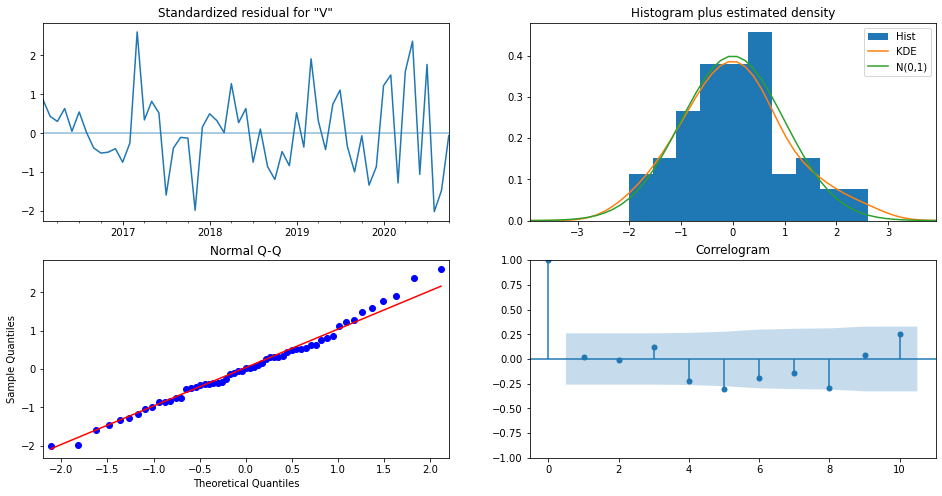

In [198]:
# Plot Diagnostics to Check Residuals for Model 1
model_aic.plot_diagnostics(figsize=(16, 8))
plt.show()

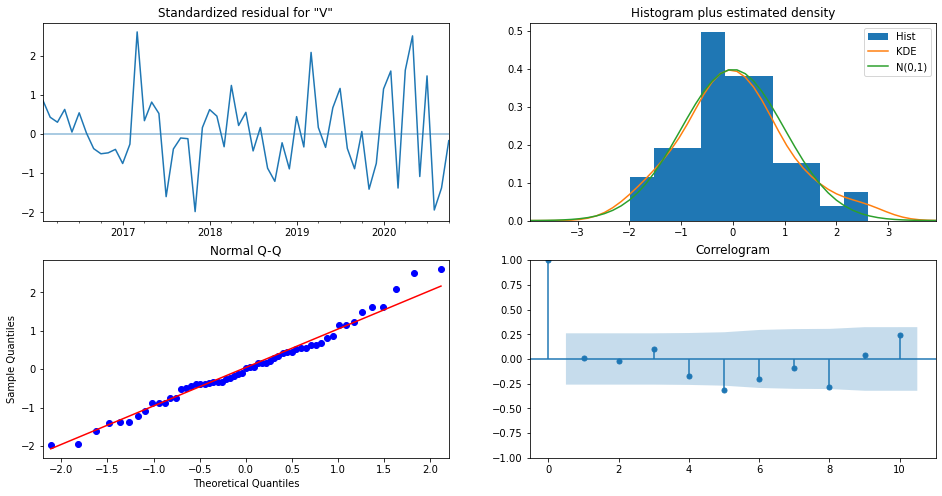

In [214]:
# Plot Diagnostics to Check Residuals for Model 5
model_aic_5.plot_diagnostics(figsize=(16, 8))
plt.show()

Based on the results from the Q-Q plot, we can see that we almost have a straight line for both models, which suggests no systematic departure from normality. Additionally, the correlogram plot on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise.

Plot Top 2 Predicted Models
- Model 1: SARIMAX(0, 1, 0)x(1, 0, 1, 12)
- Model 5: SARIMAX(0, 1, 0)x(1, 0, 0, 12)

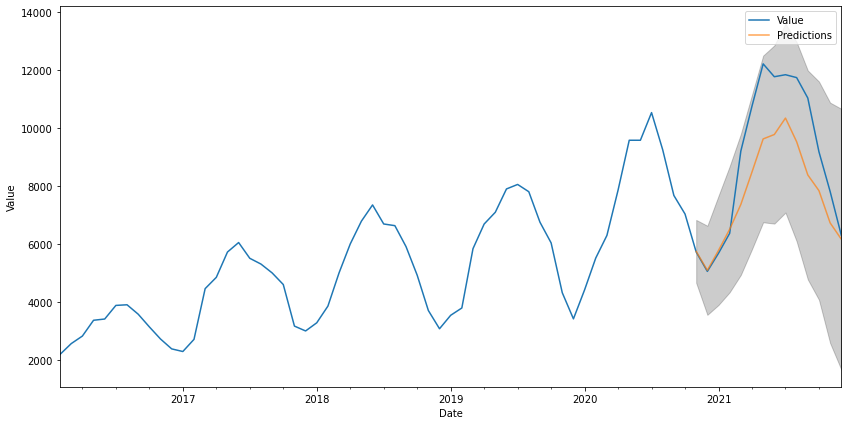

In [278]:
# Plot the Observed vs. Predicted Plots for Model 1
forecast = model_aic.get_forecast(steps=14)

# Predictions and Confidence Interval
predictions = forecast.predicted_mean
ci = forecast.conf_int()

# Observed Plot
fig = final_solar_supply_df.drop(columns=['Diff_1']).plot(label='Observed', figsize=(14, 7))
fig.set_xlabel('Date')
fig.set_ylabel('Value')
fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1],
                color = 'k',
                alpha =.2)

# Prediction Plot for Model 1
predictions.plot(ax = fig, label = 'Predictions', alpha = .7, figsize = (14, 7))

plt.legend()
plt.show()

In [247]:
# Create DataFrame of Observed Values
final_solar_supply_df.hvplot.table(columns=['Date', 'Value'], sortable=True, selectable=True)

:Table   [Date,Value]

In [248]:
# Create Table of Predicted Values for Model 1
predictions = forecast.predicted_mean
predictions_df = pd.DataFrame(predictions)
predictions.hvplot.table(columns=['predicted_mean'], sortable=True, selectable=True)

:Table   [predicted_mean]

In [275]:
# Store Values for Model 1
model_1_predictions = [5746, 5095, 5781, 6510, 7364, 8481, 9621, 9772, 10339, 9524, 8380, 7838, 6730, 6169]
actual = [5724, 5058, 5683, 6370, 9203, 10751, 12206, 11763, 11832, 11733, 11029, 9176, 7812, 6306]

In [276]:
# Calculate RMSE for Model 1
sqrt(mean_squared_error(actual, model_1_predictions)) 

1610.631020971062

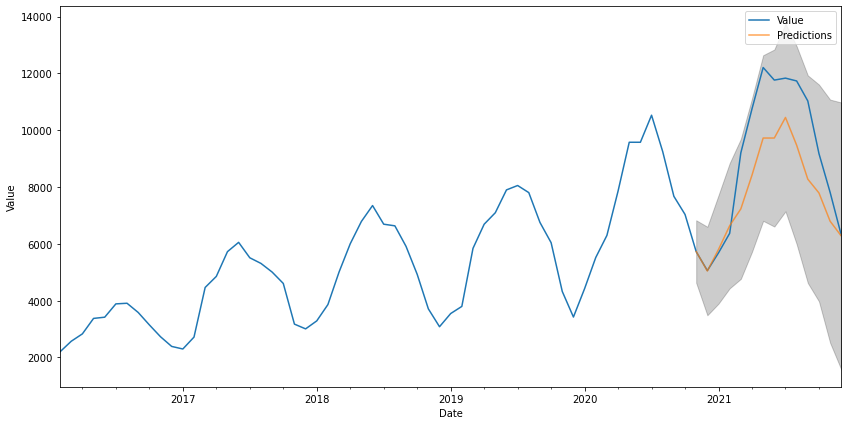

In [291]:
# Plot the Observed vs. Predicted Plots for Model 5
forecast = model_aic_5.get_forecast(steps=14)

# Predictions and Confidence Interval
predictions = forecast.predicted_mean
ci = forecast.conf_int()

# Observed Plot
fig = final_solar_supply_df.drop(columns=['Diff_1']).plot(label='Observed', figsize=(14, 7))
fig.set_xlabel('Date')
fig.set_ylabel('Value')
fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1],
                color = 'k',
                alpha =.2)

# Prediction Plot for Model 5
predictions.plot(ax = fig, label = 'Predictions', alpha = .7, figsize = (14, 7))

plt.legend()
plt.show()

In [292]:
# Create Table of Predicted Values for Model 5
predictions_5 = forecast.predicted_mean
predictions_5_df = pd.DataFrame(predictions_5)
predictions_5_df.hvplot.table(columns=['predicted_mean'], sortable=True, selectable=True)

:Table   [predicted_mean]

In [283]:
# Store Values for Model 5
model_5_predictions = [5727, 5043, 5803, 6637, 7229, 8417, 9724, 9724, 10448, 9473, 8276, 7790, 6796, 6275]
actual = [5724, 5058, 5683, 6370, 9203, 10751, 12206, 11763, 11832, 11733, 11029, 9176, 7812, 6306]

In [284]:
# Calculate RMSE for Model 5
sqrt(mean_squared_error(actual, model_5_predictions)) 

1632.357585124744

In [293]:
# Plot Data for Analysis
(final_solar_supply_df.hvplot(y='Value', kind='scatter', width=3000) +
final_solar_supply_df.hvplot.table(['Value'], width=420))

:Layout
   .Scatter.I :Scatter   [Date]   (Value)
   .Table.I   :Table   [Value]

As we can see from our original dataset in the plot above, there is a significant increase in Utility-Scale Solar Electricity Net Generation from 2016 to 2021.  This is likely due to more solar utility-scale panels being installed or optimized overtime. Because our training data was looking at the earlier years when there was far less solar energy being produced, that ultimately skewed our results, including the mean squared error results.  In future models, one way that we could optimize this would be to limit the dataset to a specific location (e.g. hospital or university campus microgrid) where there haven't been any new solar panels installations within the designated timeframe and see how the model performs.